# Example usage of ABCI-DiBS-GP

This notebook illustrates the example usage of ABCI using DiBS for approximate graph posterior inference
and a GP mechanism model.

In [9]:
# imports
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch.distributions as dist
from matplotlib.ticker import MaxNLocator

from src.abci_dibs_gp import ABCIDiBSGP as ABCI
from src.environments.generic_environments import *
from src.models.gp_model import *

First, we generate a ground truth environment/SCM.


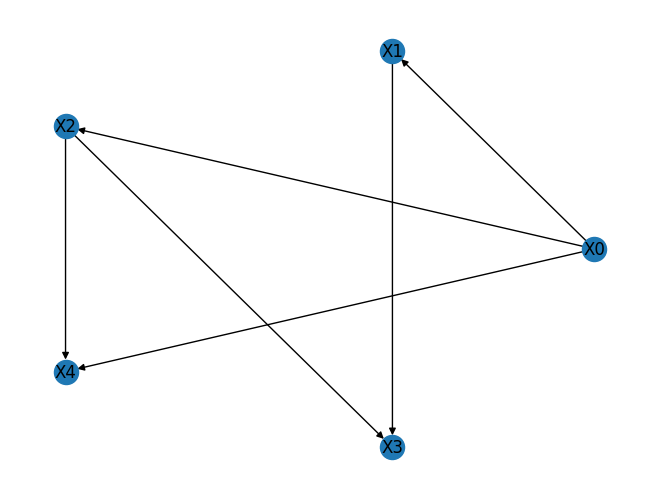

In [10]:
# specify the number of nodes and (optionally) a query of interventional variables
num_nodes = 5
interventional_queries = None
# interventional_queries = [InterventionalDistributionsQuery(['X2'], {'X1': dist.Uniform(2., 5.)})]

# generate the ground truth environment
env = BarabasiAlbert(num_nodes,
            num_test_queries=50,
            interventional_queries=interventional_queries)

# plot true graph
nx.draw(env.graph, nx.circular_layout(env.graph), labels=dict(zip(env.graph.nodes, env.graph.nodes)))

Here, we create an ABCI instance with the desired experimental design policy.

In [11]:
policy = 'graph-info-gain'
abci = ABCI(env, policy, num_particles=5, num_mc_graphs=40, num_workers=1, dibs_plus=True, linear=False)

We can now run a number of ABCI loops.

In [12]:
num_experiments = 2
batch_size = 3

abci.run(num_experiments, batch_size, num_initial_obs_samples=3)

Starting experiment cycle 1/2...
Design and perform experiment...
Updating latent particles via SVGD...
Updating 79 GP's hyperparams with first 1 experiments.
Step 1 of 500, negative log posterior is 33.813232421875...
Updating 1 GP's hyperparams with first 1 experiments.
Step 26 of 500, negative log posterior is 27.341785430908203...
Step 51 of 500, negative log posterior is 26.483264923095703...
Stopping particle updates early in iteration 66 after improvement stagnates...
Discarding 0 old mechanisms...
Discarding 0 old topological orders...
There are currently 80 unique mechanisms in our model...
Logging evaluation stats...
Experiment 1/2, ESHD is 5.162705421447754
Starting experiment cycle 2/2...
Design and perform experiment...
Expected information gain for observational sample is 1.1183950901031494.
Start experiment design for node X2 at 12:24:38


The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
Input data is not contained to the unit cube. Please consider min-max scaling the input data.
Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable', 'differentiable', 'fused'].
Keyword arguments ['lr', 'disp'] will be ignored because they are not allowed parameters for function ExpMAStoppingCriterion. Allowed parameters are ['maxiter', 'minimize', 'n_window', 'eta', 'rel_tol'].


Expected information gain for {'X2': tensor(0.7143)} is 1.149007797241211.
Start experiment design for node X4 at 12:24:54
Expected information gain for {'X4': tensor(-2.1429)} is 1.0734281539916992.
Start experiment design for node X1 at 12:25:09
Expected information gain for {'X1': tensor(5.8571)} is 0.73764967918396.
Start experiment design for node X0 at 12:25:22
Expected information gain for {'X0': tensor(4.7143)} is 1.0757170915603638.
Start experiment design for node X3 at 12:25:47
Expected information gain for {'X3': tensor(0.1429)} is 1.1124505996704102.
Resampling particles [1, 2, 0] according to weights tensor([0.1056, 0.1810, 0.1392, 0.3441, 0.2302]) (kept 2/2
Discarding 80 old mechanisms...
Discarding 458 old topological orders...
Updating latent particles via SVGD...
Updating 73 GP's hyperparams with first 2 experiments.
Step 1 of 500, negative log posterior is 55.02274703979492...
Updating 3 GP's hyperparams with first 2 experiments.
Updating 2 GP's hyperparams with firs

Here, we plot the training stats and results.

Number of observational batches: 1
Number of interventional batches on X0: 0
Number of interventional batches on X1: 0
Number of interventional batches on X2: 1
Number of interventional batches on X3: 0
Number of interventional batches on X4: 0


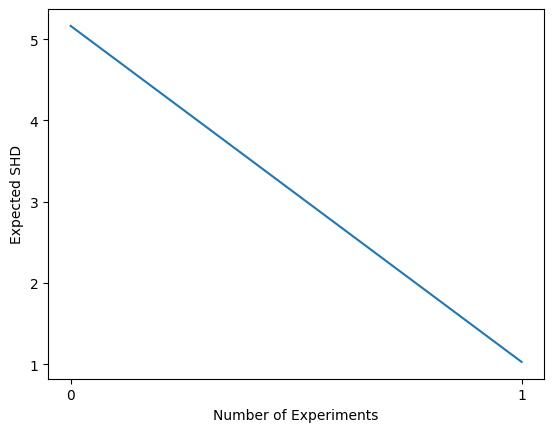

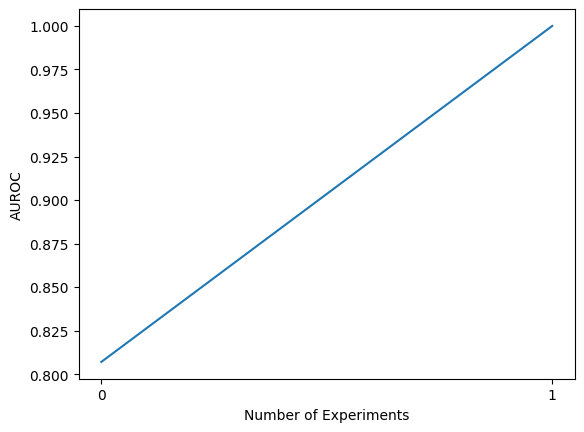

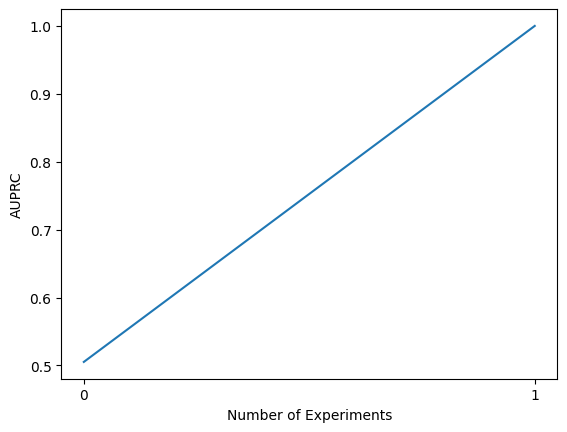

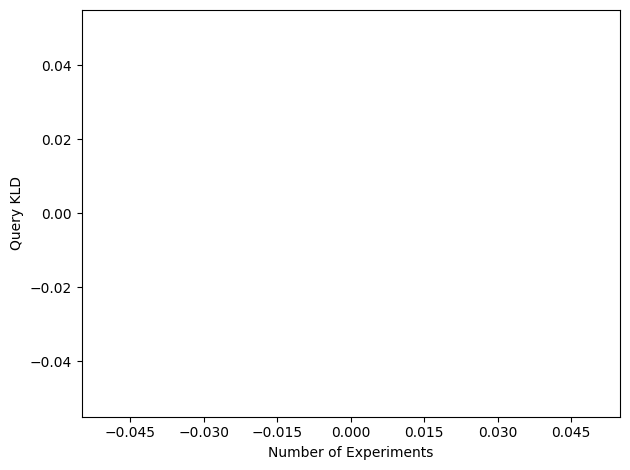

In [13]:
print(f'Number of observational batches: {len([e for e in abci.experiments if e.interventions == {}])}')
for node in env.node_labels:
    print(
        f'Number of interventional batches on {node}: {len([e for e in abci.experiments if node in e.interventions])}')

# plot expected SHD over experiments
ax = plt.figure().gca()
plt.plot(abci.eshd_list)
plt.xlabel('Number of Experiments')
plt.ylabel('Expected SHD')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot auroc over experiments
ax = plt.figure().gca()
plt.plot(abci.auroc_list)
plt.xlabel('Number of Experiments')
plt.ylabel('AUROC')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot auprc over experiments
ax = plt.figure().gca()
plt.plot(abci.auprc_list)
plt.xlabel('Number of Experiments')
plt.ylabel('AUPRC')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot Query KLD over experiments
ax = plt.figure().gca()
plt.plot(abci.query_kld_list)
plt.xlabel('Number of Experiments')
plt.ylabel('Query KLD')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

Finally, we can have a look at the learned vs. true mechanisms.

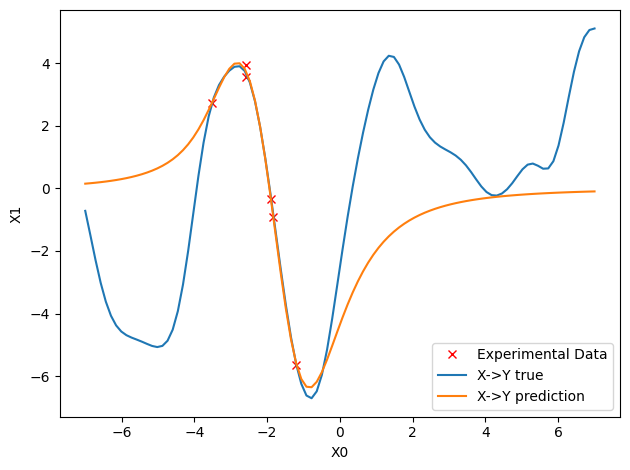

In [14]:
# plot X_i -> X_j true vs. predicted
i = 0
j = 1
xdata, ydata = gather_data(abci.experiments, f'X{j}', parents=[f'X{i}'])
xrange = torch.linspace(-7., 7., 100).unsqueeze(-1)
ytrue = env.mechanisms[f'X{j}'](xrange).detach()
mech = abci.mechanism_model.get_mechanism(f'X{j}', parents=[f'X{i}'])
mech.set_data(xdata, ydata)
ypred = mech(xrange).detach()

plt.figure()
plt.plot(xdata, ydata, 'rx', label='Experimental Data')
plt.plot(xrange, ytrue, label='X->Y true')
plt.plot(xrange, ypred, label='X->Y prediction')
plt.xlabel(f'X{i}')
plt.ylabel(f'X{j}')
plt.legend()
plt.tight_layout()

In [15]:
# plot bivariate mechanisms
node = 'X2'
num_points = 100
xrange = torch.linspace(-7., 7., num_points)
yrange = torch.linspace(-7., 7., num_points)
xgrid, ygrid = torch.meshgrid(xrange, yrange)
inputs = torch.stack((xgrid, ygrid), dim=2).view(-1, 2)
ztrue = env.mechanisms[node](inputs).detach().view(num_points, num_points).numpy()

parents = ['X0', 'X1']
mech = abci.mechanism_model.get_mechanism(node, parents=parents)
sample_inputs, sample_targets = gather_data(abci.experiments, node, parents=parents)
mech.set_data(sample_inputs, sample_targets)
zpred = mech(inputs)
zpred = zpred.detach().view(num_points, num_points).numpy()

zmin = ztrue.min().item()
zmax = ztrue.max().item()
print(f'Function values for {node} in range [{zmin, zmax}].')

levels = torch.linspace(zmin, zmax, 30).numpy()
fig, axes = plt.subplots(1, 2)
cp1 = axes[0].contourf(xgrid, ygrid, ztrue, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax,
                       antialiased=False)
cp2 = axes[1].contourf(xgrid, ygrid, zpred, cmap=plt.get_cmap('jet'), levels=levels, vmin=zmin, vmax=zmax,
                       antialiased=False)

axes[0].plot(sample_inputs[:, 0], sample_inputs[:, 1], 'kx')
axes[0].set_xlabel(parents[0])
axes[1].set_xlabel(parents[0])
axes[0].set_ylabel(parents[1])
_ = fig.colorbar(cp2)

Ill-shaped inputs: torch.Size([10000, 2])


AssertionError: None